# Import Libraries

In [1]:
# perform standard imports
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from operator import itemgetter
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# Clean Data

In [2]:
#chnages all nan to 0's
housingData = pd.read_csv("Amestrain.csv", error_bad_lines=False).fillna(0)
numericalData = housingData.select_dtypes(include=['int64','float64'])
numericalHeaders = list(numericalData)
nonNumericalData = housingData.drop(numericalHeaders, axis=1)
nonNumericalDataHeaders = list(nonNumericalData)
dummies = pd.get_dummies(housingData[nonNumericalDataHeaders])
housingData = housingData.drop(nonNumericalData, axis=1)
housingData = pd.concat([housingData,dummies],axis=1)
housingData.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


# Correlation

In [3]:
correlationMatrix = housingData.corr()
priceCorrelation = correlationMatrix['SalePrice']
# Gathering terms with correlation greater than .4
filtCorr = priceCorrelation > .4
filtData = priceCorrelation[filtCorr]

In [4]:
#get list of items
corrData = []
for row in filtData.index:
    corrData.append(row)
    
# create data frame with correlated data
Xcorr = housingData[corrData]
Xcorr = Xcorr.drop(columns=['SalePrice'])
Y = housingData['SalePrice']

# Build Model

In [9]:
grid = 10**np.linspace(-2,2,100)

np.random.seed(0)

train = np.random.choice([True, False], size=len(housingData))

X_Train = Xcorr[train]
Y_Train = Y[train]
X_Test = Xcorr[~train]
Y_Test = Y[~train]

coeffecients = np.empty((len(grid), Xcorr.shape[1]))

for index, alpha in enumerate(grid):
    lasso = Lasso(alpha=alpha, normalize = True, max_iter=50000)
    pipeline=Pipeline([('lasso', lasso)])
    pipeline.fit(X_Train, Y_Train)
    coeffecients[index] = lasso.coef_[np.newaxis]

Text(0, 0.5, 'Lasso Coefficients')

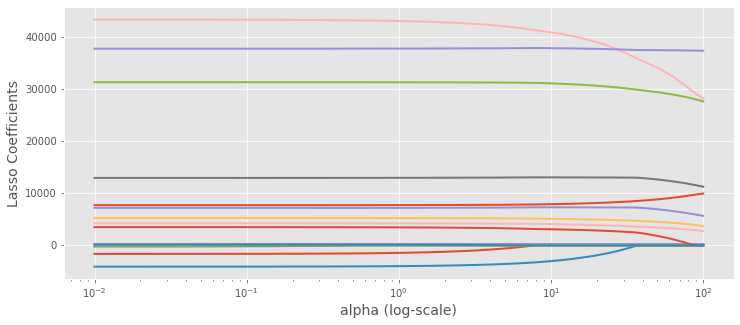

In [10]:
fig, ax = plt.subplots(figsize =(12,5))

ax.plot(grid, coeffecients, linewidth = 2)

ax.set_xscale('log')
ax.set_xlabel('alpha (log-scale)', fontsize =14)
ax.set_ylabel('Lasso Coefficients', fontsize=14)



In [11]:
scores = list()
np.random.seed(0)

for alpha in grid:
    lasso = Lasso(alpha=alpha, normalize=True, max_iter=50000)
    
    pipeline = Pipeline([('lasso', lasso)])
    
    thisScore = -cross_val_score(pipeline, Xcorr, Y, cv=10)
    scores.append(np.mean(thisScore))

-0.8086133278585113
14.174741629268063


Text(0.5, 0, 'alpha (Log-Scale)')

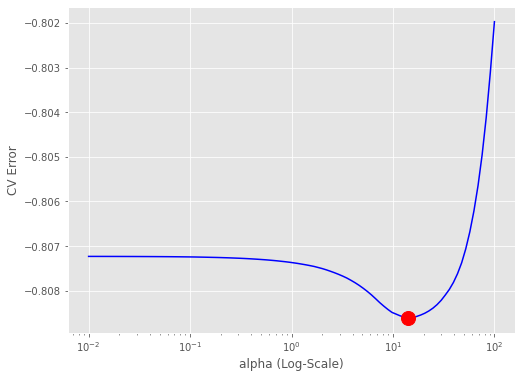

In [12]:
minIndex, minScore = min(enumerate(scores), key=itemgetter(1))
print(minScore)
print(grid[minIndex])

fig,ax = plt.subplots(figsize=(8,6))

ax.plot(grid,scores, color='b')
ax.plot(grid[minIndex],minScore,marker='o', color='r',markersize=14)

ax.set_xscale('log')
ax.set_ylabel('CV Error')
ax.set_xlabel('alpha (Log-Scale)')

In [13]:
lass = Lasso(alpha=grid[minIndex],normalize=True, max_iter=50000)
lasso.fit(X_Train, Y_Train)

mse = np.mean((lasso.predict(X_Test)-Y_Test)**2)
df = pd.Series(data = np.hstack([lasso.intercept_,lasso.coef_]), index=['Intercept']+Xcorr.columns.tolist())
df

Intercept              -777406.741748
OverallQual               9938.500225
YearBuilt                  174.670113
YearRemodAdd               206.906662
MasVnrArea                  13.592872
TotalBsmtSF                 29.489384
1stFlrSF                     0.000000
GrLivArea                   54.587148
FullBath                     0.000000
TotRmsAbvGrd                 0.000000
Fireplaces                5646.150909
GarageCars                   0.000000
GarageArea                  29.320727
Neighborhood_NridgHt         0.000000
ExterQual_Ex             28216.190353
ExterQual_Gd                 0.000000
Foundation_PConc             0.000000
BsmtQual_Ex              37372.160836
BsmtFinType1_GLQ         11241.669757
HeatingQC_Ex              3671.037452
KitchenQual_Ex           27635.870033
GarageFinish_Fin          2736.802475
dtype: float64